# 02 - RL Training

Train PPO agent for airfoil optimization.

In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from src.optimization.multi_objective_env import MultiObjectiveAirfoilEnv

## Create Environment

In [2]:
env = MultiObjectiveAirfoilEnv()
obs, info = env.reset()
print(f"Observation shape: {obs.shape}")
print(f"Action space: {env.action_space}")

Observation shape: (9,)
Action space: Box([-0.004 -0.04  -0.008], [0.004 0.04  0.008], (3,), float32)


## Train Agent

In [3]:
# Load pre-trained model instead of training from scratch
# (Training from scratch takes ~8 minutes for 50,000 steps)

import os
if os.path.exists("../models/ppo_airfoil_final.zip"):
    model = PPO.load("../models/ppo_airfoil_final.zip", env=env)
    print("✅ Loaded pre-trained model from ../models/ppo_airfoil_final.zip")
else:
    # Create and train model if no pre-trained model exists
    model = PPO(
        "MlpPolicy",
        env,
        learning_rate=3e-4,
        n_steps=2048,
        batch_size=64,
        n_epochs=10,
        gamma=0.99,
        verbose=1
    )
    print("Training model for 5000 steps (demo)...")
    model.learn(total_timesteps=5000, progress_bar=True)
    model.save("../models/ppo_trained_notebook")
    print("✅ Model trained and saved")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
✅ Loaded pre-trained model from ../models/ppo_airfoil_final.zip


## Evaluate Agent

In [4]:
# Run optimization episode
obs, info = env.reset()
trajectory = []

for step in range(env.max_steps):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    
    # Extract L/D from objectives
    objectives = info.get('objectives', {})
    ld = objectives.get('ld_mean', 0)
    
    trajectory.append({
        'step': step,
        'params': env.params.copy(),
        'ld': ld,
        'reward': reward
    })
    
    if terminated or truncated:
        break

print(f"✅ Optimization complete! Steps: {len(trajectory)}")
print(f"   Best L/D: {max([t['ld'] for t in trajectory]):.2f}")
print(f"   Final reward: {trajectory[-1]['reward']:.2f}")

✅ Optimization complete! Steps: 40
   Best L/D: 15.78
   Final reward: 0.77


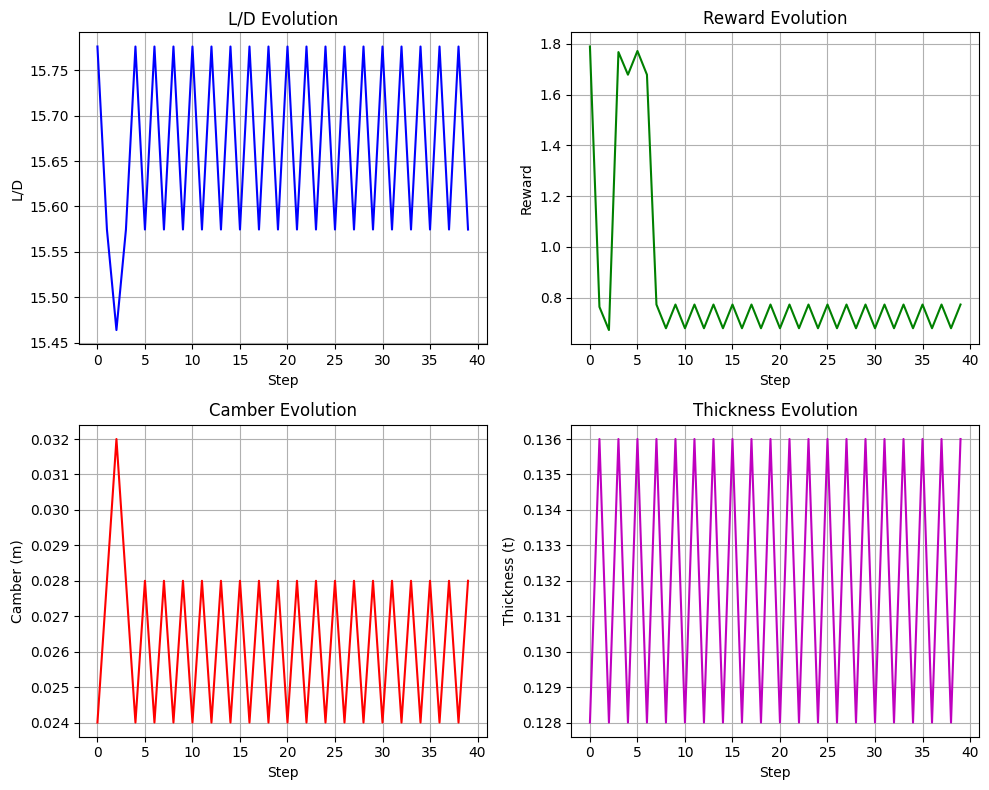


Final L/D: 15.57
Final params: m=0.0280, t=0.1360


In [5]:
# Plot results
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

steps = [t['step'] for t in trajectory]
lds = [t['ld'] for t in trajectory]
rewards = [t['reward'] for t in trajectory]
ms = [t['params'][0] for t in trajectory]
ts = [t['params'][2] for t in trajectory]

axes[0, 0].plot(steps, lds, 'b-')
axes[0, 0].set_xlabel('Step')
axes[0, 0].set_ylabel('L/D')
axes[0, 0].set_title('L/D Evolution')
axes[0, 0].grid(True)

axes[0, 1].plot(steps, rewards, 'g-')
axes[0, 1].set_xlabel('Step')
axes[0, 1].set_ylabel('Reward')
axes[0, 1].set_title('Reward Evolution')
axes[0, 1].grid(True)

axes[1, 0].plot(steps, ms, 'r-')
axes[1, 0].set_xlabel('Step')
axes[1, 0].set_ylabel('Camber (m)')
axes[1, 0].set_title('Camber Evolution')
axes[1, 0].grid(True)

axes[1, 1].plot(steps, ts, 'm-')
axes[1, 1].set_xlabel('Step')
axes[1, 1].set_ylabel('Thickness (t)')
axes[1, 1].set_title('Thickness Evolution')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

print(f"\nFinal L/D: {lds[-1]:.2f}")
print(f"Final params: m={ms[-1]:.4f}, t={ts[-1]:.4f}")